In [2]:
import mlgrad.avragg as avragg
import mlgrad.func as func

import numpy as np

In [3]:
f = func.Sqrt(0.001)
pf = avragg.PenaltyAverage(f)
avrfunc = avragg.Average_Iterative(pf)

In [4]:
Y = np.random.random(size=10000000)
Y = Y*Y

In [5]:
%time avrfunc.fit(Y)
print(avrfunc.u, avrfunc.K)

CPU times: user 2.69 s, sys: 1.97 ms, total: 2.69 s
Wall time: 675 ms
0.24835632730965276 35


In [6]:
%time np.median(Y)

CPU times: user 204 ms, sys: 216 µs, total: 204 ms
Wall time: 168 ms


0.2501110165653384

In [7]:
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook', 'seaborn-white'])

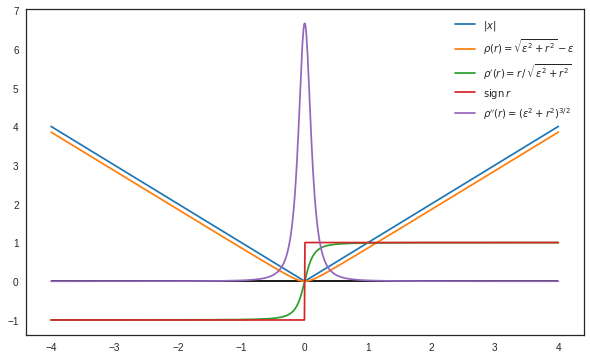

In [8]:
e=0.15
plt.figure(figsize=(10,6))
X = np.linspace(-4., 4., 1000)
plt.plot(X, np.abs(X), label=r'$|x|$')
plt.plot(X, np.sqrt(e*e+X*X)-e, label=r'$\rho(r)=\sqrt{\varepsilon^2+r^2}-\varepsilon$')
plt.plot(X, X/np.sqrt(e*e+X*X), label=r'$\rho^\prime(r)=r\,/\,\sqrt{\varepsilon^2+r^2}$')
plt.plot(X, np.sign(X), label=r'$\mathrm{sign}\,r$')
plt.plot(X, (e*e)/(e*e+X*X)**1.5, label=r'$\rho^{\prime\prime}(r)=(\varepsilon^2+r^2)^{3/2}$')
plt.hlines(0, -4, 4)
plt.minorticks_on()
plt.legend(loc='upper right')
plt.savefig('fig/smoothed_median_rho.eps')
plt.show()

In [9]:
#%load_ext cython

In [10]:
# %%cython --compile-args=-fopenmp --link-args=-fopenmp --force

# from openmp cimport omp_get_num_procs

# cdef int n = 0

# n = omp_get_num_procs()

# print(n)

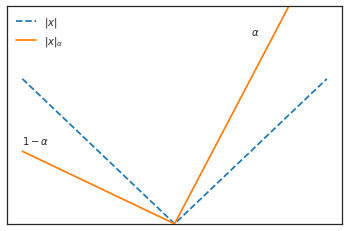

In [21]:
plt.plot([-1,0,1], [1,0,1], label=r'$|x|$', linestyle='--')
plt.plot([-1,0,1], [0.5,0,2], label=r'$|x|_\alpha$')
plt.text(-1,0.55, r'$1-\alpha$')
plt.text(0.5,1.3, r'$\alpha$')
plt.legend()
plt.ylim(0,1.5)
plt.xticks([],[])
plt.yticks([],[])
plt.savefig('fig/abs_alpha.eps')
plt.show()

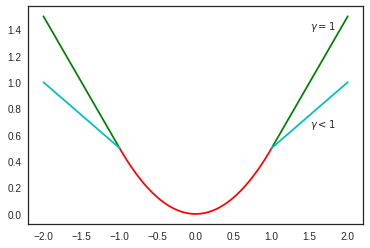

In [39]:
X0 = np.linspace(-1,1,50)
plt.plot(X0, 0.5*X0**2, color='r')
plt.plot([1,2], [0.5,1.5], color='g')
plt.plot([-2,-1], [1.5,0.5], color='g')
plt.plot([1,2], [0.5,1.0], color='c')
plt.plot([-2,-1], [1.0,0.5], color='c')
plt.text(1.5,0.66, r'$\gamma<1$')
plt.text(1.5,1.4, r'$\gamma=1$')
# plt.xticks([],[])
# plt.yticks([],[])
plt.savefig('fig/huber.eps')
plt.show()